In [1]:
using GraphMakie
using CSV
using DataFrames
using DelimitedFiles
using SankeyPlots
using ColorSchemes
using Plots
using PlotThemes

theme(:ggplot2)

In [2]:
Tree = Matrix(DataFrame(CSV.File("data/tree_matrix.csv")))



5508×5509 Matrix{Int64}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0 

In [3]:
complex_names = vec(readdlm("data/complex_names.txt", '\t', String, '\n'))
monomer_names = vec(readdlm("data/protein_names.txt", '\t', String, '\n'))
cofactor_names = vec(readdlm("data/cofactor_names.txt", '\t', String, '\n'))
element_names = vec(readdlm("data/element_names.txt", '\t', String, '\n'))

protein_names = [complex_names; monomer_names]

C = Matrix(DataFrame(CSV.File("data/C_matrix.csv", header=false)))
P = Matrix(DataFrame(CSV.File("data/P_matrix.csv", header=false)))
E = Matrix(DataFrame(CSV.File("data/E_matrix.csv", header=false)))

counts = vec(Matrix(DataFrame(CSV.File("data/counts.csv", header=false))))


5488-element Vector{Int64}:
   31
   86
 1049
 2617
  171
  485
  523
   59
 2036
   98
   47
  111
   18
    ⋮
    0
    1
    0
    1
  115
    9
   34
    0
    0
  522
    0
   39

In [4]:
Counts = repeat(counts, 1, length(monomer_names))

C_counts = C .* Counts

C_counts_elements = C_counts * P * E

5488×18 Matrix{Int64}:
    0  0      0     0  0     0  0    0  …     0  0  0    0  0  0  0  0      0
    0  0      0  1548  0  4644  0  344     2580  0  0    0  0  0  0  0      0
 2098  0      0     0  0     0  0    0        0  0  0    0  0  0  0  0      0
    0  0  10468     0  0     0  0    0        0  0  0    0  0  0  0  0  10468
 1710  0      0     0  0     0  0    0        0  0  0    0  0  0  0  0      0
    0  0      0     0  0     0  0    0  …     0  0  0    0  0  0  0  0      0
 2092  0      0     0  0     0  0    0        0  0  0    0  0  0  0  0      0
  118  0      0     0  0     0  0    0        0  0  0    0  0  0  0  0      0
    0  0      0     0  0     0  0    0        0  0  0    0  0  0  0  0      0
    0  0      0     0  0     0  0    0        0  0  0    0  0  0  0  0      0
    0  0      0    94  0   752  0   94  …   564  0  0    0  0  0  0  0      0
    0  0      0     0  0     0  0    0        0  0  0    0  0  0  0  0      0
    0  0      0     0  0     0  0    0   

In [5]:
n_cofactors_sum

LoadError: UndefVarError: `n_cofactors_sum` not defined

In [6]:
vec(sum(top_complex_cofactor_map, dims=1))

LoadError: UndefVarError: `top_complex_cofactor_map` not defined

In [7]:
[1,2,3,4,5]

5-element Vector{Int64}:
 1
 2
 3
 4
 5

In [8]:
cofactor_colors

LoadError: UndefVarError: `cofactor_colors` not defined

# Create Sankey diagram of where the iron flows in the cell.

In [39]:
# get top 10 iron
cur_element = "FE"
element_idx = element_names .== cur_element
top_included = 30

cofactors_with_element_idx = vec(E[:, element_idx] .!= 0)

complexes_by_this_element = vec(C_counts_elements[:, element_idx])
top_element_content_indices = sortperm(complexes_by_this_element, rev=true)[1:top_included]

top_complex_cofactor_map = (C_counts * P)[top_element_content_indices, cofactors_with_element_idx]


src = Vector{Int64}()
dst = Vector{Int64}()
weights = Vector{Int64}()

ordering_cofactors = Vector{Pair{Int64, Int64}}()

n_cplx = size(top_complex_cofactor_map)[1]
n_cofactor = size(top_complex_cofactor_map)[2]

selected_cofactor_names = cofactor_names[cofactors_with_element_idx]

node_labels = [cur_element; 
                selected_cofactor_names; 
                protein_names[top_element_content_indices];
                ["Remaining $c" for c ∈ selected_cofactor_names]]

colors = zeros(Int64, length(node_labels))

element_color = 1
other_color = 1+n_cofactor+1
cofactor_colors = collect(2:(n_cofactor+1))
cplx_colors = zeros(n_cplx)


n_cofactors_sum = vec(sum((C_counts * P), dims=1))[cofactors_with_element_idx]
n_cofactors_sum_elementwise = n_cofactors_sum .* E[cofactors_with_element_idx, element_idx]

remaining_cofactors = n_cofactors_sum - vec(sum(top_complex_cofactor_map, dims=1))

# element color
colors[1] = element_color
colors[2:(n_cofactor+1)] = cofactor_colors

for j in 1:n_cofactor
    push!(src, 1)
    push!(dst, 1+j)
    push!(weights, n_cofactors_sum_elementwise[j])
end

for j in 1:n_cofactor
    for i in 1:n_cplx
        if top_complex_cofactor_map[i,j] != 0
            push!(src, 1+j)
            push!(dst, 1+n_cofactor + i)
            push!(weights, top_complex_cofactor_map[i,j] * E[cofactors_with_element_idx, element_idx][j])    
            
            colors[1+n_cofactor+i] = cofactor_colors[j]
        end
    end
    
    # remaining
    push!(src, 1 + j)
    push!(dst, 1 + n_cofactor + n_cplx + j)
    push!(weights, remaining_cofactors[j] * E[cofactors_with_element_idx, element_idx][j])
    
end

# remaining colors
colors[colors .== 0] .= other_color


# create sorting

sort_cofactors = sortperm(vec(n_cofactors_sum_elementwise), rev=true)


for i in 1:(n_cofactor-1)
    
    
    push!(ordering_cofactors, 1+sort_cofactors[i]=>1+sort_cofactors[i+1])
end


already_sorted = Vector{Int64}()

for i in sort_cofactors
    name = node_labels[1+i]
    # println("currently sorting $name")
    # exclude last element since redundant
    sorted_column = sortperm(top_complex_cofactor_map[:, i], rev=true)
    nonzero = sum(top_complex_cofactor_map[sorted_column, i] .> 0)
    
    for j in 1:length(sorted_column[1:nonzero-1])
        
        
        cplx_name = node_labels[1+n_cofactor+sorted_column[j]]
        downstream = node_labels[1+n_cofactor+sorted_column[j+1]]
        
        count = top_complex_cofactor_map[sorted_column[j], i]
        
        # println("currently sorting $cplx_name with count $count")
        
        if !(sorted_column[j] in already_sorted || sorted_column[j+1] in already_sorted)
            
            # println("Connecting node $cplx_name with $downstream")
            
            push!(ordering_cofactors, 
                        1+n_cofactor+sorted_column[j] => 1+n_cofactor+sorted_column[j+1])


        end
    end
    
    append!(already_sorted, sorted_column[1:nonzero-1])
    
end

# create internal sorting of largest cofactor sizes



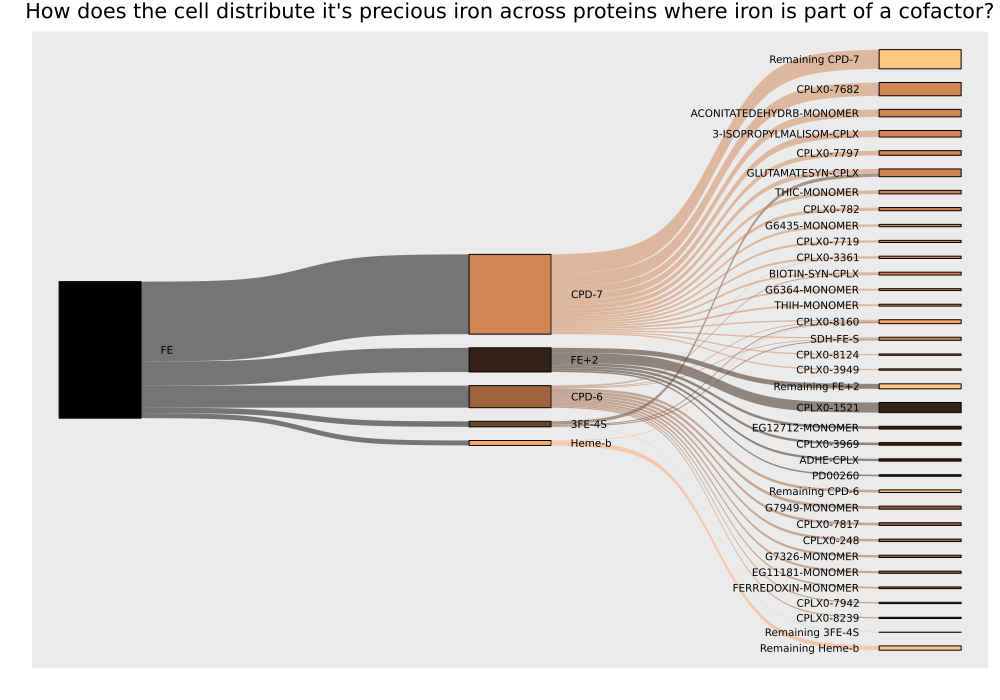

In [42]:
sankey(src, dst, weights, 
        compact = true,
        node_labels = node_labels,
        node_colors = cgrad(:copper, maximum(colors), categorical = true)[colors],
        edge_color = :src,
        size=(1000, 700),
        #label_position = :inside,
        label_size = 7,
        force_order = ordering_cofactors,
        title="How does the cell distribute it's precious iron across proteins where iron is part of a cofactor?"
)

# savefig("iron_cofactor_plot_biggg.png")

In [11]:
findfirst(contains("NAP-CPLX"), protein_names)

100

In [12]:
counts[100]

2674

In [13]:
cgrad(:matter, length(node_labels), categorical = true)

# How many ions of interest seem to be bound in the cell?

In [14]:
element_names

18-element Vector{String}:
 "MG"
 "R"
 "S"
 "N"
 "H"
 "C"
 "NI"
 "P"
 "K"
 "O"
 "MO"
 "CU"
 "ZN"
 "NA"
 "MN"
 "CA"
 "CO"
 "FE"

In [43]:
cur_elements = ["FE", "MN", "ZN", "NI", "CA", "CU"]
element_idx = [element in cur_elements for element in element_names]

display_element_names = element_names[element_idx]

element_counts = vec(sum(C_counts_elements[:, element_idx], dims=1))

6-element Vector{Int64}:
   8625
   4872
 149239
  40243
  10028
 219263

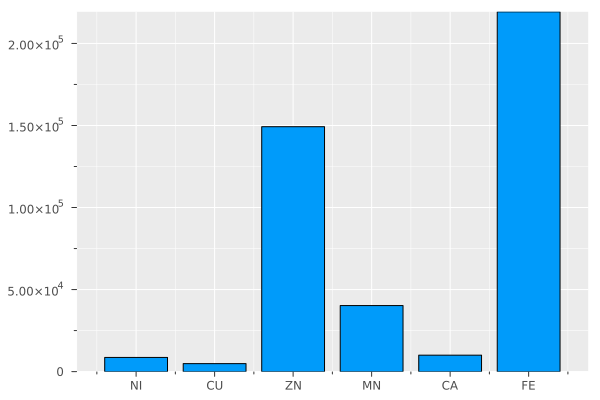

In [44]:
plot(bar(display_element_names, element_counts), legend = false)

# For rarer metals, where do they bind?

In [86]:
cur_elements = ["MN", "ZN", "NI", "CA", "MO"]
top_included = 30

element_idx = [element in cur_elements for element in element_names]
display_element_names = element_names[element_idx]

top_complex_idx_by_counts = sortperm(vec(sum(C_counts_elements[:, element_idx], dims=2)), rev=true)[1:top_included]


top_complex_cofactor_map = C_counts_elements[top_complex_idx_by_counts, element_idx]
selected_cofactor_names = cofactor_names[top_complex_idx_by_counts]

node_labels = [display_element_names; 
                protein_names[top_element_content_indices];
#                ["Remaining $c" for c ∈ selected_cofactor_names]
]


n_cplx, n_cofactor = size(top_complex_cofactor_map)

src = Vector{Int64}()
dst = Vector{Int64}()
weights = Vector{Int64}()

for j in 1:n_cofactor
    for i in 1:n_cplx
        if top_complex_cofactor_map[i,j] != 0
            push!(src, 1+j)
            push!(dst, 1+n_cofactor + i)
            push!(weights, top_complex_cofactor_map[i,j])    
            
            # colors[1+n_cofactor+i] = cofactor_colors[j]
        end
    end
    
    # # remaining
    # push!(src, 1 + j)
    # push!(dst, 1 + n_cofactor + n_cplx + j)
    # push!(weights, remaining_cofactors[j] * E[cofactors_with_element_idx, element_idx][j])
    
end

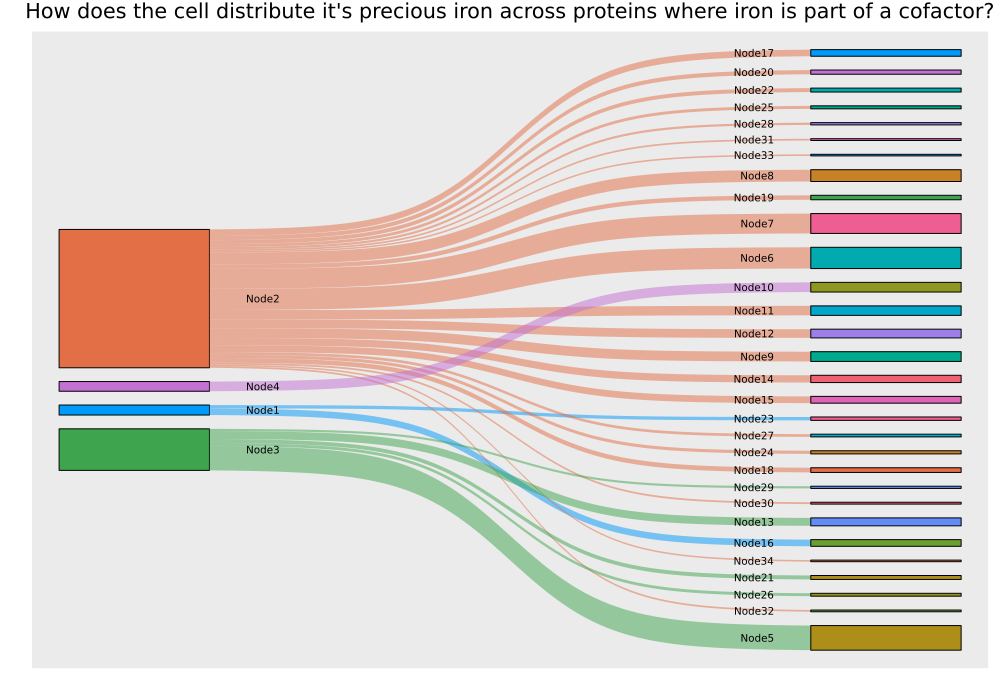

In [90]:
sankey(src, dst, weights, 
        compact = true,
        # node_labels = node_labels,
        # node_colors = cgrad(:copper, maximum(colors), categorical = true)[colors],
        edge_color = :src,
        size=(1000, 700),
        #label_position = :inside,
        label_size = 7,
        force_order = ordering_cofactors,
        title="How does the cell distribute it's precious iron across proteins where iron is part of a cofactor?"
)

# savefig("iron_cofactor_plot_biggg.png")

In [60]:
for j in 1:n_cofactor
    for i in 1:n_cplx
        if top_complex_cofactor_map[i,j] != 0
            push!(src, 1+j)
            push!(dst, 1+n_cofactor + i)
            push!(weights, top_complex_cofactor_map[i,j] * E[cofactors_with_element_idx, element_idx][j])    
            
            colors[1+n_cofactor+i] = cofactor_colors[j]
        end
    end
    
    # remaining
    push!(src, 1 + j)
    push!(dst, 1 + n_cofactor + n_cplx + j)
    push!(weights, remaining_cofactors[j] * E[cofactors_with_element_idx, element_idx][j])
    
end

30-element Vector{CartesianIndex{2}}:
 CartesianIndex(436, 6)
 CartesianIndex(1023, 4)
 CartesianIndex(4444, 3)
 CartesianIndex(197, 6)
 CartesianIndex(838, 3)
 CartesianIndex(857, 6)
 CartesianIndex(1098, 6)
 CartesianIndex(4, 6)
 CartesianIndex(118, 3)
 CartesianIndex(1340, 3)
 CartesianIndex(598, 5)
 CartesianIndex(377, 3)
 CartesianIndex(493, 6)
 ⋮
 CartesianIndex(797, 3)
 CartesianIndex(385, 1)
 CartesianIndex(100, 3)
 CartesianIndex(511, 6)
 CartesianIndex(5196, 6)
 CartesianIndex(4311, 6)
 CartesianIndex(136, 6)
 CartesianIndex(2708, 6)
 CartesianIndex(503, 6)
 CartesianIndex(350, 6)
 CartesianIndex(249, 6)
 CartesianIndex(1494, 3)